In [ ]:
#install dependencies

!pip install rdkit

!pip install torch_geometric
!pip install torch

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21

In [ ]:
#load the data and check that the sdf and the QM features are the same length (499)

from rdkit import Chem
import torch
import numpy as np

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load QM features from .npy file
qm_features = np.load("/content/drive/My Drive/combined_dataset_with_deltafreq.npy", allow_pickle=True)

# Load molecular structures from SDF
sdf_file = "/content/drive/My Drive/acetone_water_all.sdf"
suppl = Chem.SDMolSupplier(sdf_file, removeHs=False)

print(f"✅ Loaded {len(suppl)} molecules from {sdf_file}.")

# Verify data consistency
assert len(qm_features) == len(suppl), "Mismatch between QM dataset and SDF molecules!"

#print(f"✅ Loaded {len(qm_features)} QM data entries and {len(suppl)} molecules.")

# Print min and max values for each feature column
#print("Min values per feature:", np.min(qm_features, axis=0))
#print("Max values per feature:", np.max(qm_features, axis=0))

from sklearn.preprocessing import StandardScaler
import numpy as np

# Initialize scaler
scaler = StandardScaler()

# Normalize dataset using StandardScaler
scaler = StandardScaler()
qm_features_normalized = scaler.fit_transform(qm_features)  # Normalized dataset

# Compute target mean and std (for de-normalization later)
target_mean = scaler.mean_[315:355]
target_std = scaler.scale_[315:355]



print("✅ Normalized QM features using StandardScaler!")
print("✅ Stored mean and std for de-normalization!")



Mounted at /content/drive
✅ Loaded 499 molecules from /content/drive/My Drive/acetone_water_all.sdf.
✅ Normalized QM features using StandardScaler!
✅ Stored mean and std for de-normalization!


In [ ]:
from torch_geometric.data import Data
from rdkit import Chem



# Define device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def sdf_to_graph(sdf_file, qm_features):
    """Convert SDF + QM data into graph representations."""
    suppl = Chem.SDMolSupplier(sdf_file, removeHs=False)
    dataset = []

    for idx, mol in enumerate(suppl):
        if mol is None:
            continue

        # Extract node features: Atomic Number
        node_features = torch.tensor([[atom.GetAtomicNum()] for atom in mol.GetAtoms()], dtype=torch.float)

        # Extract edges (bond connectivity)
        edge_index = []
        for bond in mol.GetBonds():
            a1 = bond.GetBeginAtomIdx()  # ✅ Fix: Assign separately
            a2 = bond.GetEndAtomIdx()
            edge_index.append([a1, a2])
            edge_index.append([a2, a1])  # Undirected graph

        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

        # Extract QM global features (excluding Δfreq, columns 315-355)
        qm_graph_features = torch.tensor(qm_features[idx, :315], dtype=torch.float)  # First 315 QM properties

        # Extract vibrational Δfreq columns (315 to 355)
        target_value = torch.tensor([qm_features[idx,315: 355]], dtype=torch.float)  # Extract only column 355



        # Create PyTorch Geometric Data object
        data = Data(
            x=node_features,
            edge_index=edge_index,
            y=target_value,
            qm=qm_graph_features
        )

        dataset.append(data)

    return dataset


dataset = sdf_to_graph(sdf_file, qm_features_normalized)





from torch_geometric.loader import DataLoader

# Define DataLoader for batch processing
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Print dataset size
print(f"✅ Training set size: {len(train_loader.dataset)}")


<ipython-input-3-0159dade6266>:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  target_value = torch.tensor([qm_features[idx,315: 355]], dtype=torch.float)  # Extract only column 355


✅ Training set size: 499


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader

# Define device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Multi-Target GNN Model (Predicts 40 Δfreq values)
class MultiTargetGNN(nn.Module):
    def __init__(self, num_node_features, qm_feature_dim=315):
        super(MultiTargetGNN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 128)  # More hidden units
        self.conv2 = GCNConv(128, 128)
        #self.conv3 = GCNConv(64, 64)  # Add a third GCN layer
        self.fc = nn.Linear(128 + qm_feature_dim, 40)
        # Predict all 40 Δfreq values

    def forward(self, data):
        x, edge_index, qm_features = data.x, data.edge_index, data.qm

        if edge_index.numel() == 0:
            raise ValueError("❌ Empty edge_index detected in batch!")

        # Apply GNN layers
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()

        # Pool over nodes to get graph representation
        x = global_mean_pool(x, data.batch)

        # Ensure `qm_features` has the correct batch shape
        qm_features = data.qm.view(data.num_graphs, -1)  # Match batch size

        # Concatenate graph embeddings with QM features
        x = torch.cat([x, qm_features], dim=1)

        return self.fc(x)  # Returns shape (batch_size, 40)


In [ ]:
# Initialize Model and Optimizer
model = MultiTargetGNN(num_node_features=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = nn.MSELoss()  # Mean Squared Error Loss

# Training Loop
num_epochs = 500
patience = 20  # Early stopping
best_loss = float("inf")
no_improve_epochs = 0
loss_values = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        batch = batch.to(device)

        if batch.edge_index.numel() == 0:
            print("⚠️ Skipping batch with empty edge_index")
            continue

        optimizer.zero_grad()
        pred_deltafreqs = model(batch)  # Predict all 40 Δfreq values

        # Extract all target values (Δfreq 315-354)
        batch_targets = batch.y.view(batch.num_graphs, -1)  # Shape: (batch_size, 40)

        # Compute loss across all 40 targets
        loss = loss_fn(pred_deltafreqs, batch_targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_values.append(avg_loss)

    # 🚀 Early Stopping Logic
    if avg_loss < best_loss:
        best_loss = avg_loss
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1

    if no_improve_epochs >= patience:
        print(f"🛑 Early stopping at epoch {epoch+1}, loss: {avg_loss:.4f}")
        break

    if (epoch + 1) % 10 == 0:
        print(f"  🔹 Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

torch.save(model.state_dict(), "multi_target_gnn.pth")  # Save trained model


  🔹 Epoch 10/500, Loss: 0.1978
  🔹 Epoch 20/500, Loss: 0.1249
  🔹 Epoch 30/500, Loss: 0.0909
  🔹 Epoch 40/500, Loss: 0.0704
  🔹 Epoch 50/500, Loss: 0.0572
  🔹 Epoch 60/500, Loss: 0.0456
  🔹 Epoch 70/500, Loss: 0.0371
  🔹 Epoch 80/500, Loss: 0.0302
  🔹 Epoch 90/500, Loss: 0.0243
  🔹 Epoch 100/500, Loss: 0.0203
  🔹 Epoch 110/500, Loss: 0.0164
  🔹 Epoch 120/500, Loss: 0.0132
  🔹 Epoch 130/500, Loss: 0.0110
  🔹 Epoch 140/500, Loss: 0.0088
  🔹 Epoch 150/500, Loss: 0.0071
  🔹 Epoch 160/500, Loss: 0.0056
  🔹 Epoch 170/500, Loss: 0.0047
  🔹 Epoch 180/500, Loss: 0.0036
  🔹 Epoch 190/500, Loss: 0.0029
  🔹 Epoch 200/500, Loss: 0.0023
  🔹 Epoch 210/500, Loss: 0.0019
  🔹 Epoch 220/500, Loss: 0.0016
  🔹 Epoch 230/500, Loss: 0.0013
  🔹 Epoch 240/500, Loss: 0.0010
  🔹 Epoch 250/500, Loss: 0.0009
  🔹 Epoch 260/500, Loss: 0.0007
  🔹 Epoch 270/500, Loss: 0.0009
  🔹 Epoch 280/500, Loss: 0.0006
  🔹 Epoch 290/500, Loss: 0.0005
  🔹 Epoch 300/500, Loss: 0.0005
  🔹 Epoch 310/500, Loss: 0.0006
  🔹 Epoch 320/500

In [ ]:
target_mean = scaler.mean_[315:355]  # Assuming first 315 are QM features
target_std = scaler.scale_[315:355]


# Function to de-normalize predictions
def denormalize_predictions(predictions, target_mean, target_std):
    """Convert normalized predictions back to actual Δfreq values."""
    return predictions * target_std + target_mean


# Model Evaluation
model.eval()
true_values_dict = {}
predicted_values_dict = {}

with torch.no_grad():
    for batch in train_loader:
        batch = batch.to(device)
        pred = model(batch)  # Get predictions for all 40 targets

        # Convert to numpy arrays
        batch_targets = batch.y.view(batch.num_graphs, -1).cpu().numpy()
        batch_preds = pred.cpu().numpy()

        # De-normalize predictions
        batch_targets = denormalize_predictions(batch_targets, target_mean, target_std)
        batch_preds = denormalize_predictions(batch_preds, target_mean, target_std)

        for i, target_col in enumerate(range(315, 355)):
            if target_col not in true_values_dict:
                true_values_dict[target_col] = []
                predicted_values_dict[target_col] = []

            true_values_dict[target_col].extend(batch_targets[:, i])
            predicted_values_dict[target_col].extend(batch_preds[:, i])


In [ ]:
#compute residuals

import numpy as np

residuals_dict = {}  # Store residuals for each target

for target_col in range(315, 355):
    if target_col in true_values_dict and target_col in predicted_values_dict:
        residuals = np.array(true_values_dict[target_col]) - np.array(predicted_values_dict[target_col])
        residuals_dict[target_col] = residuals  # Store residuals for plotting


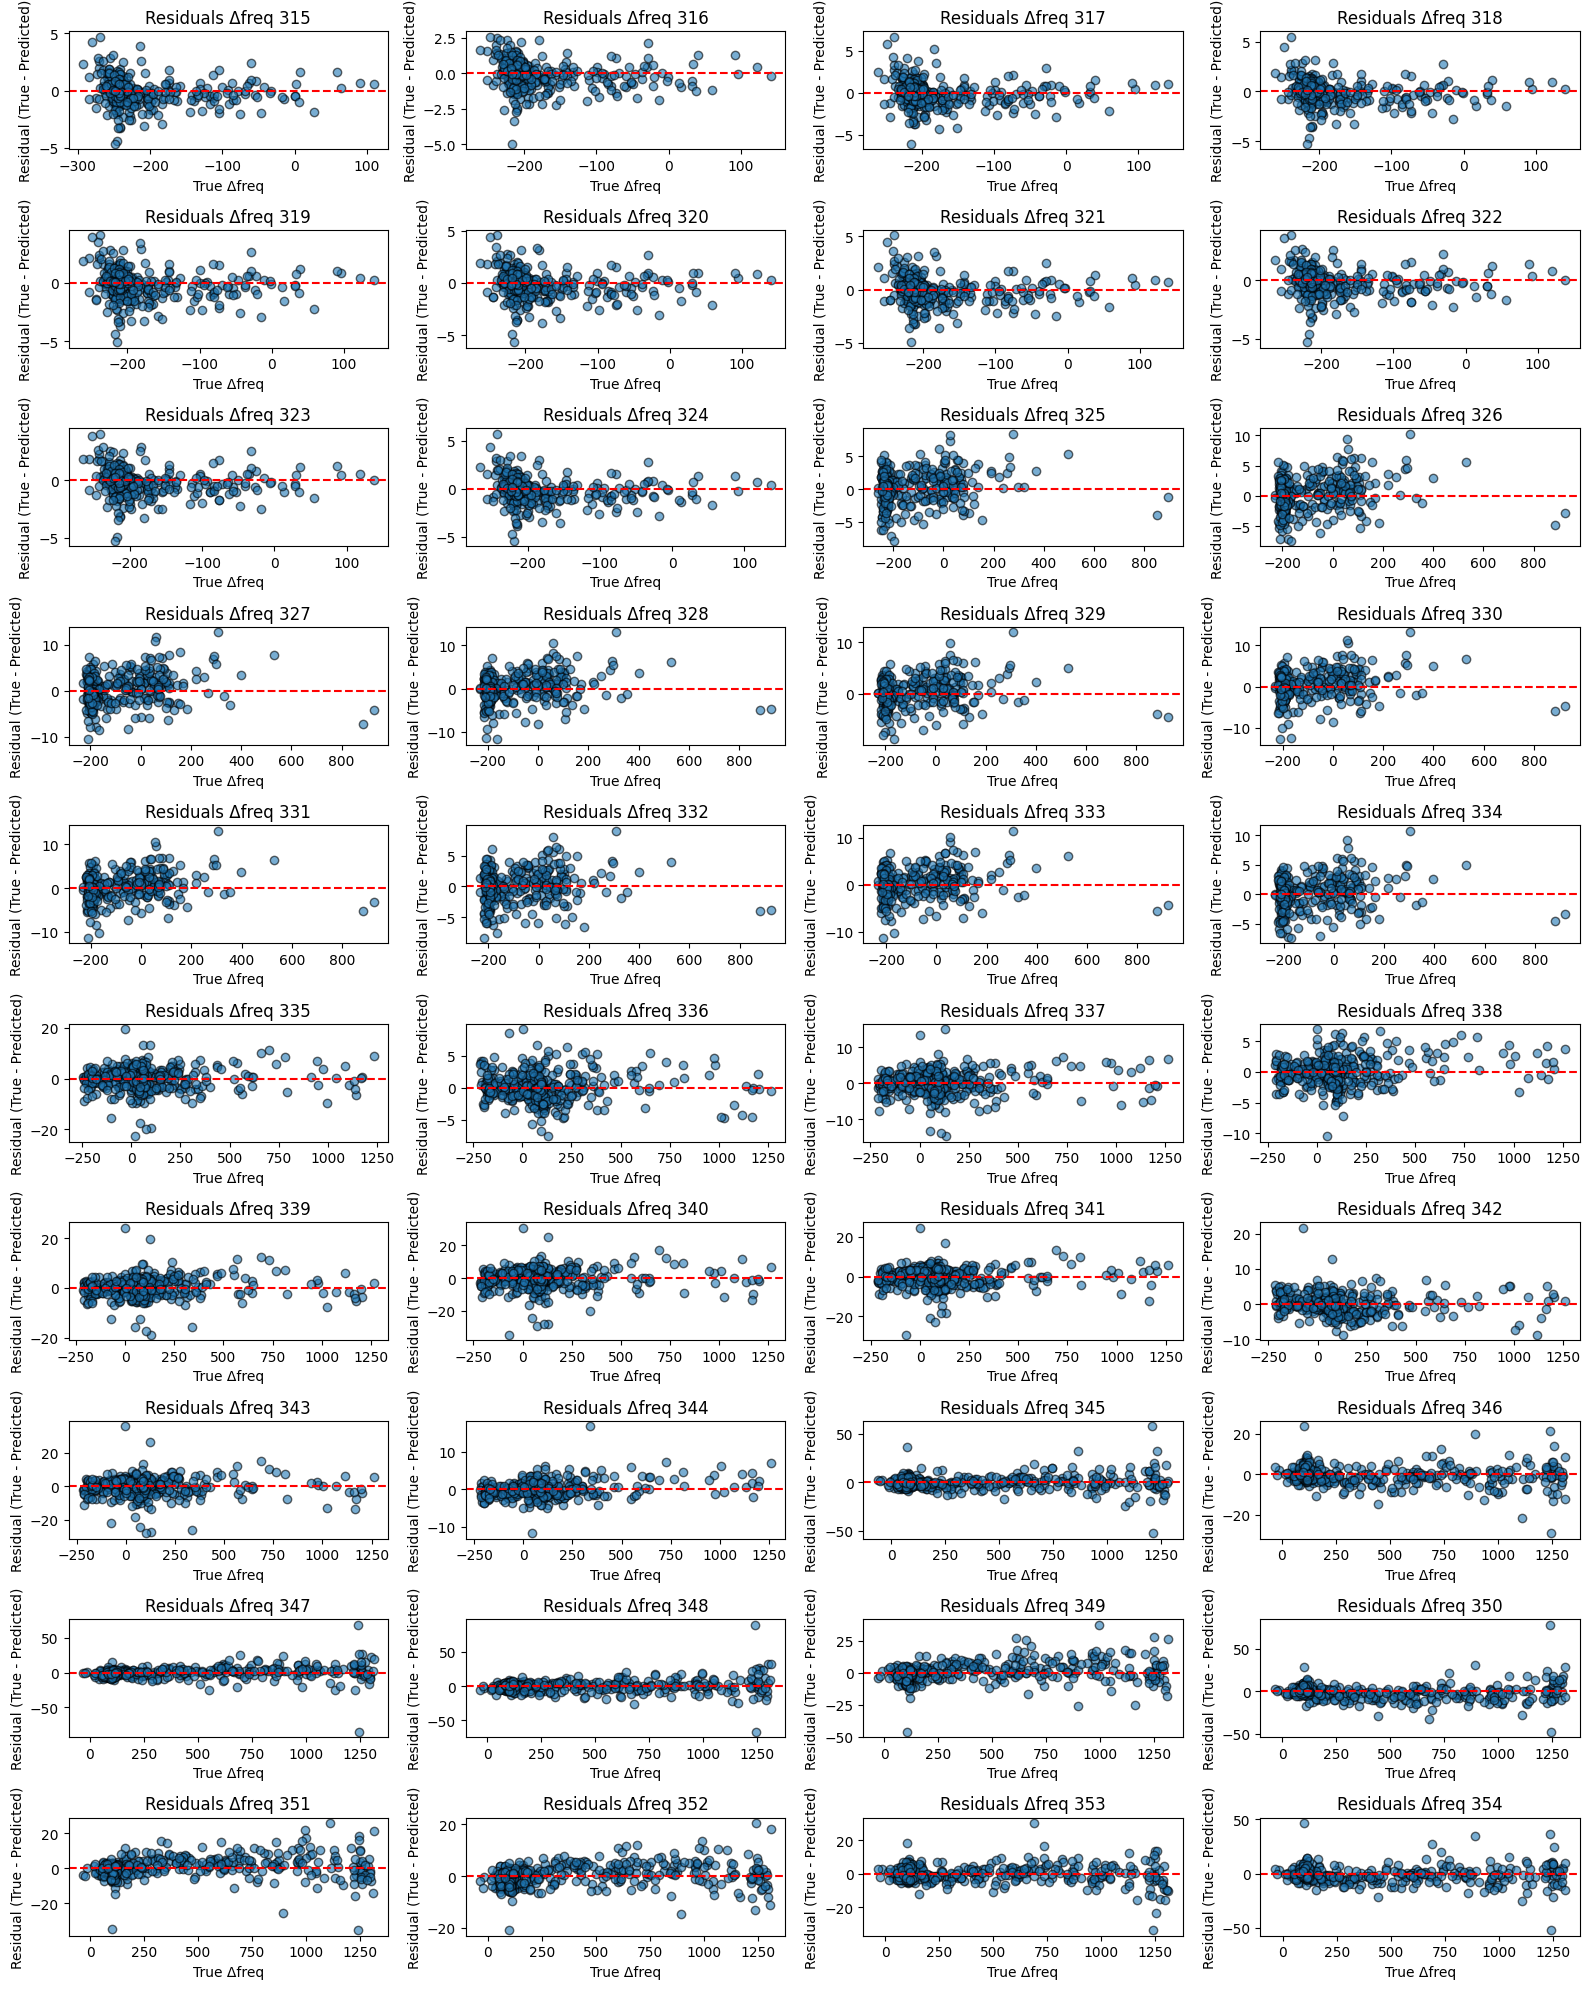

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(16, 20))
axes = axes.flatten()

for i, target_col in enumerate(range(315, 355)):
    ax = axes[i]

    if target_col in residuals_dict:
        ax.scatter(true_values_dict[target_col], residuals_dict[target_col], alpha=0.6, edgecolors='k')
        ax.axhline(0, color='red', linestyle='--')  # Zero-error reference line
        ax.set_xlabel("True Δfreq")
        ax.set_ylabel("Residual (True - Predicted)")
        ax.set_title(f"Residuals Δfreq {target_col}")

plt.tight_layout()
plt.show()